<a href="https://colab.research.google.com/github/maciejskorski/NonobliviousRademacherProjections/blob/main/notebooks/OptimalRademacherEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn import random_projection

def calculate_sparsity(A):
    sparsity = 1 - np.count_nonzero(A)/np.product(A.shape)
    return sparsity

for num_dimensions in [10000,100000,1000000,10000000]:
    distortion = 0
    sparsity = 0
    X = np.random.rand(100, num_dimensions)

    sparsity_original = calculate_sparsity(X)

    print("sparsity original")
    print(sparsity_original)
    for density in [0.1,0.25,0.5,0.75, 'auto']:

        for i in range(15):
            transformer = random_projection.SparseRandomProjection(density=density)
            X_new = transformer.fit_transform(X)

            distortion = distortion + np.abs((np.linalg.norm(X_new,ord=2) - np.linalg.norm(X,ord=2)))
            sparsity = sparsity + calculate_sparsity(X_new)


        print("X_new")
        print(X_new.shape)
        print("average sparsity random projection")
        print(sparsity/(i+1))
        print("density")
        print(density)
        print("distortion")
        print(distortion/(i+1))

sparsity original
0.0
X_new
(100, 3947)
average sparsity random projection
0.0
density
0.1
distortion
4.941938576658174
X_new
(100, 3947)
average sparsity random projection
0.0
density
0.25
distortion
10.393311076703473
X_new
(100, 3947)
average sparsity random projection
0.0
density
0.5
distortion
14.943950741612628
X_new
(100, 3947)
average sparsity random projection
0.0
density
0.75
distortion
19.29242303180447
X_new
(100, 3947)
average sparsity random projection
0.0
density
auto
distortion
24.802943619904134
sparsity original
0.0


In [ ]:
import numpy as np
from sklearn.random_projection import SparseRandomProjection
import seaborn as sns

X = np.random.rand(1,100)
X /= np.linalg.norm(X,ord=2,axis=1,keepdims=True)

X.shape

(1, 100)

# Input sparsity vs empirical distortion

Suppose that we project a vector with $L$ non-zero components, from $n_{input}$ to $n_{embed}$ dimensions with an appropriate matrix $P$.

* How does the distortion $\|P x\|^2 / \|x\|^2$ depend on $L$?
* How does the distortion depend on the embeddibg sparsity $p$?

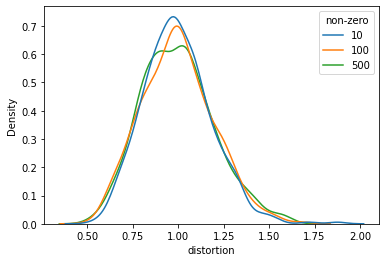

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.random_projection import SparseRandomProjection


N_SAMPLES = 1000 # number of randomized projection restarts
N_INPUT = 500 # length of projection input
N_EMBED = 50 # length of projection output
L = [10,100,500] # number of non-zero components (sparsity). Note: L is used in papers on comprehensive sensing
outs = []
for l in L:
  # build vectors with L non-zero components out of N_INPUT
  X = np.zeros((N_INPUT,))
  idxs = np.random.choice(range(N_INPUT),size=(l,),replace=False)
  X[idxs] = 1
  X = X/np.linalg.norm(X,2) # normalize input
  X = np.expand_dims(X,0) # reshape to (1,N)


  for _ in range(N_SAMPLES):
    transformer = SparseRandomProjection(n_components=N_EMBED,density=1.0)
    X_new = transformer.fit_transform(X)
    distortion = np.linalg.norm(X_new,2)**2 # squared distortion is bit smoother
    #outs.append((distortion))
    outs.append((distortion,l))

df = pd.DataFrame(outs, columns=["distortion", "non-zero"])

#sns.kdeplot(outs, legend=True)
sns.kdeplot(data=df, x="distortion", hue="non-zero", palette="tab10")

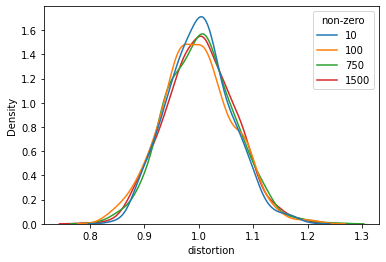

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd


N_SAMPLES = 1000 # number of randomized projection restarts
N_INPUT = 5000 # length of projection input
N_EMBED = 500 # length of projection output
L = [10,100,750,1500] # number of non-zero components (sparsity). Note: L is used in papers on comprehensive sensing
outs = []
for l in L:
  # build vectors with L non-zero components out of N_INPUT
  X = np.zeros((N_INPUT,))
  idxs = np.random.choice(range(N_INPUT),size=(l,),replace=False)
  X[idxs] = 1
  X = X/np.linalg.norm(X,2) # normalize input
  X = np.expand_dims(X,0)


  for _ in range(N_SAMPLES):
    transformer = SparseRandomProjection(n_components=N_EMBED,density=1.0)
    X_new = transformer.fit_transform(X)
    distortion = np.linalg.norm(X_new,2)**2 # squared distortion is bit smoother
    #outs.append((distortion))
    outs.append((distortion,l))

df = pd.DataFrame(outs, columns=["distortion", "non-zero"])

#sns.kdeplot(outs, legend=True)
sns.kdeplot(data=df, x="distortion", hue="non-zero", palette="tab10")

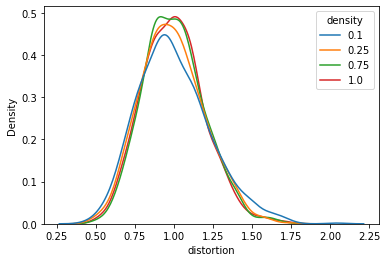

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd


N_SAMPLES = 1000 # number of randomized projection restarts
N_INPUT = 5000 # length of projection input
N_EMBED = 50 # length of projection output
L = 10 # number of non-zero components (sparsity). Note: L is used in papers on comprehensive sensing
outs = []

# build vectors with L non-zero components out of N_INPUT
X = np.zeros((N_INPUT,))
idxs = np.random.choice(range(N_INPUT),size=(L,),replace=False)
X[idxs] = 1
X = X/np.linalg.norm(X,2) # normalize input
X = np.expand_dims(X,0)

for dens in [0.1,0.25,0.75,1.0]:
  for _ in range(N_SAMPLES):
    transformer = SparseRandomProjection(n_components=N_EMBED,density=dens)
    X_new = transformer.fit_transform(X)
    distortion = np.linalg.norm(X_new,2)**2 # squared distortion is bit smoother
    #outs.append((distortion))
    outs.append((distortion,dens))

df = pd.DataFrame(outs, columns=["distortion", "density"])

#sns.kdeplot(outs, legend=True)
sns.kdeplot(data=df, x="distortion", hue="density", palette="tab10")

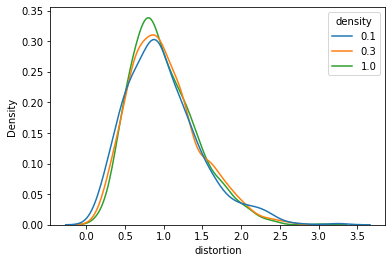

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.random_projection import SparseRandomProjection


N_SAMPLES = 1000 # number of randomized projection restarts
N_INPUT = 10000 # length of projection input
N_EMBED = 10 # length of projection output
L = 10 # number of non-zero components (sparsity). Note: L is used in papers on comprehensive sensing
outs = []

# build vectors with L non-zero components out of N_INPUT
X = np.zeros((N_INPUT,))
idxs = np.random.choice(range(N_INPUT),size=(L,),replace=False)
X[idxs] = 1
X = X/np.linalg.norm(X,2) # normalize input
X = np.expand_dims(X,0)

for dens in [0.1,0.30,1.0]:
  for _ in range(N_SAMPLES):
    transformer = SparseRandomProjection(n_components=N_EMBED,density=dens)
    X_new = transformer.fit_transform(X)
    distortion = np.linalg.norm(X_new,2)**2 # squared distortion is bit smoother
    outs.append((distortion,dens))

df = pd.DataFrame(outs, columns=["distortion", "density"])

sns.kdeplot(data=df, x="distortion", hue="density", palette="tab10")

In [ ]:
df.groupby('density').agg(['mean','std'])

distortion          
              mean       std
density                     
0.1       0.990700  0.483898
0.3       1.005833  0.447219
1.0       0.999440  0.426711

# Real world datasets experiments

##Download datasets

In [ ]:
datasets = {}

### MNIST

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.random_projection import SparseRandomProjection

mnist = tf.keras.datasets.mnist
(train_inputs, train_labels), _ = mnist.load_data()
train_inputs = train_inputs / 255.0

n_samples = 50
#n_samples = 500

subsample = np.random.random_integers(0,train_inputs.shape[0],size=n_samples)

Xs = train_inputs[subsample]

datasets['MNIST'] = Xs

11490434/11490434 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: This function is deprecated. Please call randint(0, 60000 + 1) instead
  from ipykernel import kernelapp as app


### CIFAR10

In [ ]:
from tensorflow.keras.datasets import cifar10

n_samples = 50
#n_samples = 100

(train_data,_),_ = cifar10.load_data()
subsample = np.random.random_integers(0,len(train_data),n_samples)
#cifar10 = train_data[subsample][:,:,:,0]
Xs = train_data[subsample][:,:,:,0]
#datasets = {'CIFAR10': Xs}
datasets['CIFAR10'] = Xs
#average_param_gain(Xs)

170498071/170498071 [==============================] - 4s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: This function is deprecated. Please call randint(0, 50000 + 1) instead
  import sys


### NIPS

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00371/NIPS_1987-2015.csv

import pandas as pd

n_samples = 50
#n_samples = 200

# beware that features are in rows (words)
d = pd.read_csv('NIPS_1987-2015.csv')

subsample = np.random.random_integers(0,d.shape[1],size=n_samples)
cols = d.columns[subsample]
Xs = d[cols].T
Xs = Xs.to_numpy()
Xs = [x for x in Xs]

datasets['NIPS'] = Xs

--2022-10-13 10:32:03--  https://archive.ics.uci.edu/ml/machine-learning-databases/00371/NIPS_1987-2015.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133587258 (127M) [application/x-httpd-php]
Saving to: ‘NIPS_1987-2015.csv’

NIPS_1987-2015.csv  100%[===================>] 127.40M  85.7MB/s    in 1.5s    

2022-10-13 10:32:05 (85.7 MB/s) - ‘NIPS_1987-2015.csv’ saved [133587258/133587258]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 5812 + 1) instead
  # This is added back by InteractiveShellApp.init_path()


### Mycielski

In [ ]:
import scipy.io

!wget https://suitesparse-collection-website.herokuapp.com/MM/Mycielski/mycielskian17.tar.gz
!tar -xf mycielskian17.tar.gz

n_samples = 50

file_name = 'mycielskian17/mycielskian17.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]
datasets['Mycielski'] = Xs

--2022-10-13 10:30:23--  https://suitesparse-collection-website.herokuapp.com/MM/Mycielski/mycielskian17.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 54.224.34.30, 34.201.81.34, 54.208.186.182, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|54.224.34.30|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/Mycielski/mycielskian17.tar.gz [following]
--2022-10-13 10:30:24--  http://sparse-files.engr.tamu.edu/MM/Mycielski/mycielskian17.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.177.200
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.177.200|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120811979 (115M) [application/x-tar]
Saving to: ‘mycielskian17.tar.gz’

mycielskian17.tar.g 100%[=============

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: This function is deprecated. Please call randint(0, 98303 + 1) instead
  if sys.path[0] == '':


### Goodwin

In [ ]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/Goodwin/Goodwin_040.tar.gz
!tar -xf Goodwin_040.tar.gz

n_samples = 50

file_name = 'Goodwin_040/Goodwin_040.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['Goodwin'] = Xs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. Please call randint(0, 17922 + 1) instead
  # Remove the CWD from sys.path while we load stuff.


### 1138_bus

In [ ]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/HB/1138_bus.tar.gz
!tar -xf 1138_bus.tar.gz

#n_samples = 50
n_samples = 100

file_name = '1138_bus/1138_bus.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['1138_bus'] = Xs
#Power Network Problem

--2022-10-13 10:29:07--  https://suitesparse-collection-website.herokuapp.com/MM/HB/1138_bus.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 54.208.186.182, 54.243.129.215, 34.201.81.34, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|54.208.186.182|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/HB/1138_bus.tar.gz [following]
--2022-10-13 10:29:07--  http://sparse-files.engr.tamu.edu/MM/HB/1138_bus.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.109.216
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.109.216|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19829 (19K) [application/x-tar]
Saving to: ‘1138_bus.tar.gz’

1138_bus.tar.gz     100%[===================>]  19.36K  --.-KB/s    in 0.06s   


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 1138 + 1) instead
  # This is added back by InteractiveShellApp.init_path()


### bcspwr06

In [ ]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/HB/bcspwr06.tar.gz
!tar -xf bcspwr06.tar.gz

n_samples = 50
#n_samples = 100

file_name = 'bcspwr06/bcspwr06.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['bcspwr06'] = Xs
#Power Network Problem

--2022-10-13 10:19:37--  https://suitesparse-collection-website.herokuapp.com/MM/HB/bcspwr06.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 54.224.34.30, 54.208.186.182, 34.201.81.34, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|54.224.34.30|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/HB/bcspwr06.tar.gz [following]
--2022-10-13 10:19:37--  http://sparse-files.engr.tamu.edu/MM/HB/bcspwr06.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.108.168
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.108.168|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10254 (10K) [application/x-tar]
Saving to: ‘bcspwr06.tar.gz’

bcspwr06.tar.gz     100%[===================>]  10.01K  --.-KB/s    in 0s      

202

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 1454 + 1) instead
  # This is added back by InteractiveShellApp.init_path()


### mnist_test_norm

In [ ]:
import scipy.io
!wget https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/mnist_test_norm_10NN.tar.gz
!tar -xf mnist_test_norm_10NN.tar.gz

n_samples = 50
#n_samples = 800

file_name = 'mnist_test_norm_10NN/mnist_test_norm_10NN.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['mnist_test_norm_10NN'] = Xs
#Undirected Weighted Graph

--2022-10-13 12:48:06--  https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/mnist_test_norm_10NN.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 34.201.81.34, 54.208.186.182, 54.224.34.30, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|34.201.81.34|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/ML_Graph/mnist_test_norm_10NN.tar.gz [following]
--2022-10-13 12:48:06--  http://sparse-files.engr.tamu.edu/MM/ML_Graph/mnist_test_norm_10NN.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.100.43
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.100.43|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 898856 (878K) [application/x-tar]
Saving to: ‘mnist_test_norm_10NN.tar.gz.1’

mnist_test_norm_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: This function is deprecated. Please call randint(0, 10000 + 1) instead
  if sys.path[0] == '':


### optdigit

In [ ]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/optdigits_10NN.tar.gz
!tar -xf optdigits_10NN.tar.gz

n_samples = 50
#n_samples = 400

file_name = 'optdigits_10NN/optdigits_10NN.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['optdigits_10NN'] = Xs
#Undirected Weighted Graph

--2022-10-13 09:51:26--  https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/optdigits_10NN.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 54.243.129.215, 54.208.186.182, 54.224.34.30, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|54.243.129.215|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/ML_Graph/optdigits_10NN.tar.gz [following]
--2022-10-13 09:51:27--  http://sparse-files.engr.tamu.edu/MM/ML_Graph/optdigits_10NN.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.106.184
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.106.184|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 478572 (467K) [application/x-tar]
Saving to: ‘optdigits_10NN.tar.gz’

optdigits_10NN.tar. 100%[===========

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 5620 + 1) instead
  # This is added back by InteractiveShellApp.init_path()


### plantsmargin

In [ ]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/plantsmargin_12NN.tar.gz
!tar -xf plantsmargin_12NN.tar.gz

n_samples = 50
#n_samples = 200

file_name = 'plantsmargin_12NN/plantsmargin_12NN.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['plantsmargin_12NN'] = Xs
#Undirected Weighted Graph

--2022-10-13 09:51:40--  https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/plantsmargin_12NN.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 54.243.129.215, 54.208.186.182, 54.224.34.30, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|54.243.129.215|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/ML_Graph/plantsmargin_12NN.tar.gz [following]
--2022-10-13 09:51:40--  http://sparse-files.engr.tamu.edu/MM/ML_Graph/plantsmargin_12NN.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.177.24
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.177.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151077 (148K) [application/x-tar]
Saving to: ‘plantsmargin_12NN.tar.gz’

plantsmargin_12NN.t 100%[=

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 1600 + 1) instead
  # This is added back by InteractiveShellApp.init_path()


### planstexture

In [ ]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/plantstexture_10NN.tar.gz
!tar -xf plantstexture_10NN.tar.gz

n_samples = 50
#n_samples = 200

file_name = 'plantstexture_10NN/plantstexture_10NN.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['plantstexture_10NN'] = Xs
#Undirected Weighted Graph


--2022-10-13 12:48:21--  https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/plantstexture_10NN.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 54.224.34.30, 54.208.186.182, 54.243.129.215, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|54.224.34.30|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/ML_Graph/plantstexture_10NN.tar.gz [following]
--2022-10-13 12:48:21--  http://sparse-files.engr.tamu.edu/MM/ML_Graph/plantstexture_10NN.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.176.168
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.176.168|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126369 (123K) [application/x-tar]
Saving to: ‘plantstexture_10NN.tar.gz’

plantstexture_10NN. 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 1599 + 1) instead
  # This is added back by InteractiveShellApp.init_path()


### semeion

In [ ]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/semeion_10NN.tar.gz
!tar -xf semeion_10NN.tar.gz

n_samples = 50
#n_samples = 600

file_name = 'semeion_10NN/semeion_10NN.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['semeion_10NN'] = Xs
#Undirected Weighted Graph


--2022-10-13 09:54:08--  https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/semeion_10NN.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 34.201.81.34, 54.224.34.30, 54.208.186.182, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|34.201.81.34|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/ML_Graph/semeion_10NN.tar.gz [following]
--2022-10-13 09:54:09--  http://sparse-files.engr.tamu.edu/MM/ML_Graph/semeion_10NN.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.100.227
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.100.227|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85567 (84K) [application/x-tar]
Saving to: ‘semeion_10NN.tar.gz’

semeion_10NN.tar.gz 100%[===================>]  83

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 1593 + 1) instead
  # This is added back by InteractiveShellApp.init_path()


### umistfacesnorm

In [ ]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/umistfacesnorm_10NN.tar.gz
!tar -xf umistfacesnorm_10NN.tar.gz

n_samples = 50
#n_samples = 200

file_name = 'umistfacesnorm_10NN/umistfacesnorm_10NN.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['umistfacesnorm_10NN'] = Xs
#Undirected Weighted Graph


--2022-10-13 10:15:05--  https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/umistfacesnorm_10NN.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 54.243.129.215, 54.224.34.30, 54.208.186.182, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|54.243.129.215|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/ML_Graph/umistfacesnorm_10NN.tar.gz [following]
--2022-10-13 10:15:05--  http://sparse-files.engr.tamu.edu/MM/ML_Graph/umistfacesnorm_10NN.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.96.163
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.96.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41257 (40K) [application/x-tar]
Saving to: ‘umistfacesnorm_10NN.tar.gz.1’

umistfacesnorm_10N

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 575 + 1) instead
  # This is added back by InteractiveShellApp.init_path()


### Ecoli

In [ ]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/Ecoli_10NN.tar.gz
!tar -xf Ecoli_10NN.tar.gz

n_samples = 50
#n_samples = 200

file_name = 'Ecoli_10NN/Ecoli_10NN.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['Ecoli_10NN'] = Xs
#Undirected Weighted Graph


--2022-10-13 12:48:24--  https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/Ecoli_10NN.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 54.208.186.182, 54.224.34.30, 54.243.129.215, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|54.208.186.182|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/ML_Graph/Ecoli_10NN.tar.gz [following]
--2022-10-13 12:48:24--  http://sparse-files.engr.tamu.edu/MM/ML_Graph/Ecoli_10NN.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.142.88
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.142.88|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27740 (27K) [application/x-tar]
Saving to: ‘Ecoli_10NN.tar.gz’

Ecoli_10NN.tar.gz   100%[===================>]  27.09K  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 336 + 1) instead
  # This is added back by InteractiveShellApp.init_path()


### usps_norm_5NN

In [ ]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/usps_norm_5NN.tar.gz
!tar -xf usps_norm_5NN.tar.gz

n_samples = 50
#n_samples = 300

file_name = 'usps_norm_5NN/usps_norm_5NN.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['usps_norm_5NN'] = Xs
#Undirected Weighted Graph


--2022-10-13 09:54:14--  https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/usps_norm_5NN.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 34.201.81.34, 54.208.186.182, 54.243.129.215, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|34.201.81.34|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/ML_Graph/usps_norm_5NN.tar.gz [following]
--2022-10-13 09:54:15--  http://sparse-files.engr.tamu.edu/MM/ML_Graph/usps_norm_5NN.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.101.132
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.101.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 467315 (456K) [application/x-tar]
Saving to: ‘usps_norm_5NN.tar.gz’

usps_norm_5NN.tar.g 100%[=================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 11000 + 1) instead
  # This is added back by InteractiveShellApp.init_path()


### micromass

In [ ]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/micromass_10NN.tar.gz
!tar -xf micromass_10NN.tar.gz

n_samples = 50
#n_samples = 200

file_name = 'micromass_10NN/micromass_10NN.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['micromass_10NN'] = Xs
#Undirected Weighted Graph


--2022-10-13 12:48:32--  https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/micromass_10NN.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 54.208.186.182, 54.224.34.30, 54.243.129.215, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|54.208.186.182|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/ML_Graph/micromass_10NN.tar.gz [following]
--2022-10-13 12:48:32--  http://sparse-files.engr.tamu.edu/MM/ML_Graph/micromass_10NN.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.108.160
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.108.160|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57569 (56K) [application/x-tar]
Saving to: ‘micromass_10NN.tar.gz’

micromass_10NN.tar. 100%[=============

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 571 + 1) instead
  # This is added back by InteractiveShellApp.init_path()


### lp_brandy

In [ ]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/LPnetlib/lp_brandy.tar.gz
!tar -xf lp_brandy.tar.gz

n_samples = 50
#n_samples = 200

file_name = 'lp_brandy/lp_brandy.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['lp_brandy'] = Xs
#Linear Programming


--2022-10-13 10:38:23--  https://suitesparse-collection-website.herokuapp.com/MM/LPnetlib/lp_brandy.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 54.224.34.30, 54.208.186.182, 34.201.81.34, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|54.224.34.30|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/LPnetlib/lp_brandy.tar.gz [following]
--2022-10-13 10:38:23--  http://sparse-files.engr.tamu.edu/MM/LPnetlib/lp_brandy.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.96.163
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.96.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10688 (10K) [application/x-tar]
Saving to: ‘lp_brandy.tar.gz’

lp_brandy.tar.gz    100%[===================>]  10.44K  --.-KB/s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 220 + 1) instead
  # This is added back by InteractiveShellApp.init_path()


### Glass_10NN

In [ ]:
!wget https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/Glass_10NN.tar.gz
!tar -xf Glass_10NN.tar.gz

n_samples = 50
#n_samples = 200

file_name = 'Glass_10NN/Glass_10NN.mtx'
matrix = scipy.io.mmread(file_name)
matrix = scipy.sparse.csr_matrix(matrix)

subsample = np.random.random_integers(0,matrix.shape[0],size=n_samples)

Xs = matrix[subsample]
Xs = [x.toarray() for x in Xs]

datasets['Glass_10NN'] = Xs
#Undirected Weighted Graph


--2022-10-13 12:48:17--  https://suitesparse-collection-website.herokuapp.com/MM/ML_Graph/Glass_10NN.tar.gz
Resolving suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)... 54.224.34.30, 54.208.186.182, 54.243.129.215, ...
Connecting to suitesparse-collection-website.herokuapp.com (suitesparse-collection-website.herokuapp.com)|54.224.34.30|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://sparse-files.engr.tamu.edu/MM/ML_Graph/Glass_10NN.tar.gz [following]
--2022-10-13 12:48:18--  http://sparse-files.engr.tamu.edu/MM/ML_Graph/Glass_10NN.tar.gz
Resolving sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)... 52.219.176.168
Connecting to sparse-files.engr.tamu.edu (sparse-files.engr.tamu.edu)|52.219.176.168|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19119 (19K) [application/x-tar]
Saving to: ‘Glass_10NN.tar.gz.1’

Glass_10NN.tar.gz.1 100%[===================>]  18.67K

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 214 + 1) instead
  # This is added back by InteractiveShellApp.init_path()


## Projections

In [ ]:
def calculate_sparsity(A):

  sparsity = 1 - np.count_nonzero(A)/A.size
  return sparsity

In [ ]:
datasets['CIFAR10'] = X
calculate_sparsity(X)

0.9917573483427142

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import random_projection
from sklearn.random_projection import SparseRandomProjection


N_SAMPLES = 1000 # number of randomized projection restarts
#N_INPUT = 50000 # length of projection input
N_EMBED = 50 # length of projection output
#L = ['Mycielski','Goodwin'] # number of non-zero components (sparsity). Note: L is used in papers on comprehensive sensing
#L = ['Goodwin']
#L = ['bcspwr06']
#L = ['1138_bus', 'Mycielski']
#L = ['Goodwin', 'bcspwr06']
#L = ['optdigits_10NN', 'mnist_test_norm_10NN', 'plantsmargin_12NN', 'plantstexture_10NN','semeion_10NN']
L = ['Ecoli_10NN', 'mnist_test_norm_10NN','Glass_10NN','micromass_10NN','plantstexture_10NN']

non_zero = []
outs = []
for l in L:
  print(l)

  # build vectors with L non-zero components out of N_INPUT
  X = datasets[l]

  #print(np.count_nonzero(X))
  #idxs = np.random.choice(range(N_INPUT),size=(l,),replace=False)

  #if l == 'optdigits_10NN':
  X = np.asarray(X)
  nsamples, nx, ny = X.shape
  X = X.reshape((nsamples,nx*ny))
  non_zero.append((l,calculate_sparsity(X)))
  #X[idxs] = 1
  #X = X/np.linalg.norm(X,2) # normalize input
  #X = np.expand_dims(X,0)

  for dens in [0.1,0.5,1]:
    for _ in range(N_SAMPLES):
      transformer = SparseRandomProjection(n_components=N_EMBED,density=dens)
      X_new = transformer.fit_transform(X)
      distortion = np.linalg.norm(X_new,2)**2 # squared distortion is bit smoother
      #outs.append((distortion))

      outs.append((distortion,dens,'non_zero='+str(calculate_sparsity(X_new)),l))

  #df = pd.DataFrame(outs, columns=["distortion", "density"])

  #sns.kdeplot(outs, legend=True)
  #sns.kdeplot(data=df, x="distortion", hue="density", palette="tab10")
df = pd.DataFrame(outs, columns=["distortion", "density", "non_zero", "dataset"])


In [ ]:
non_zero
df1 = pd.DataFrame(non_zero, columns=["dataset", "sparsity"])
df1 = df1.sort_values('sparsity')

In [ ]:
df1

,dataset,sparsity
2,Glass_10NN,0.935607
0,Ecoli_10NN,0.961012
3,micromass_10NN,0.971594
4,plantstexture_10NN,0.991757
1,mnist_test_norm_10NN,0.998552


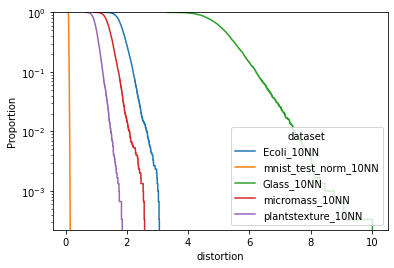

In [ ]:
sns.ecdfplot(data=df, x="distortion", hue="dataset",palette="tab10", complementary=True, log_scale=(False,True))

In [ ]:
df.to_csv('intro_plot2.csv', sep=',')

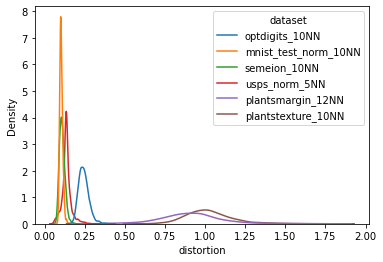

In [ ]:
sns.kdeplot(data=df, x="distortion", hue="dataset",palette="tab10")

In [ ]:

# CIFAR10 order of 1e9

# 1138_bus order 1e8

#Mycielski

#NIPS

#MNIST 20'000

# Goodwin, to be printed

# bcspwr06 has distortion around 28

# optdigit 0.6

# mnist_test_norm 0.3


# Ecoli and umistfacesnorm_10NN same range, around 8

In [ ]:
sns.lineplot(data=df, x="density",y="distortion", hue="dataset")

In [ ]:
sns.lineplot(data=df, x="density",y="distortion", hue="dataset")

#Maybe 1138_bus couls go with Mycielski or NIPS as they have very high distortion?

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
sns.lineplot(data=df, x="density",y="distortion", hue="dataset")

# Toy datasets, intro plot

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import random_projection
from sklearn.random_projection import SparseRandomProjection


N_SAMPLES = 1000 # number of randomized projection restarts
N_INPUT = 50000 # length of projection input
N_EMBED = 50 # length of projection output
L = [10,100,1000] # number of non-zero components (sparsity). Note: L is used in papers on comprehensive sensing

outs = []
for l in L:
  # build vectors with L non-zero components out of N_INPUT

  X = np.zeros((N_INPUT,))

  idxs = np.random.choice(range(N_INPUT),size=(l,),replace=False)

  X[idxs] = 1
  X = X/np.linalg.norm(X,2) # normalize input
  X = np.expand_dims(X,0)

  for dens in [0.1,0.5,1.0]:
    for _ in range(N_SAMPLES):
      transformer = SparseRandomProjection(n_components=N_EMBED,density=dens)
      X_new = transformer.fit_transform(X)
      distortion = np.linalg.norm(X_new,2)**2 # squared distortion is bit smoother
      #outs.append((distortion))
      outs.append((distortion,dens,'non_zero='+str(l)))

  #df = pd.DataFrame(outs, columns=["distortion", "density"])

  #sns.kdeplot(outs, legend=True)
  #sns.kdeplot(data=df, x="distortion", hue="density", palette="tab10")
df = pd.DataFrame(outs, columns=["distortion", "density", "non_zero"])


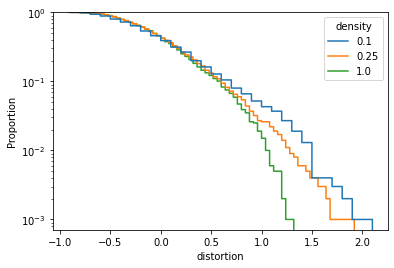

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import random_projection
from sklearn.random_projection import SparseRandomProjection


N_SAMPLES = 1000 # number of randomized projection restarts
N_INPUT = 1000 # length of projection input
N_EMBED = 10 # length of projection output
L = [10] # number of non-zero components (sparsity). Note: L is used in papers on comprehensive sensing

dens_grid = [0.1,0.25,1.0]

np.random.seed(1234)

outs = []
outs1 = []
value1 = []
value2 = []
value3 = []
final = []

for l in L:
  # build vectors with L non-zero components out of N_INPUT
  X = np.zeros((N_INPUT,))

  idxs = np.random.choice(range(N_INPUT),size=(l,),replace=False)

  X[idxs] = 1
  X = X/np.linalg.norm(X,2) # normalize input
  X = np.expand_dims(X,0)

  for dens in dens_grid:
    for i in range(N_SAMPLES):
      transformer = SparseRandomProjection(n_components=N_EMBED,density=dens)
      X_new = transformer.fit_transform(X)
      distortion = np.linalg.norm(X_new,2)**2-1 # squared distortion is bit smoother

      if dens == 0.1:
        value1.append(distortion)
      if dens == 0.25:
        value2.append(distortion)
      if dens == 1.0:
        value3.append(distortion)

      outs.append((distortion,dens))
      outs1.append((distortion,dens))

for i in range(N_SAMPLES):
  final.append((value1[i],value2[i],value3[i]))

df = pd.DataFrame(outs, columns=["distortion", "density"])
sns.ecdfplot(data=df, x="distortion", hue="density", palette="tab10",complementary=True, log_scale=(False,True))

df = pd.DataFrame(final, columns=["distortion","distortion","distortion"])
df.to_csv('intro_plot2.csv', sep=',')


In [ ]:
from matplotlib import pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
#fig,ax = plt.subplots()

xspace = np.linspace(-1,2.1,100)
ecdfs = [ECDF(df[df['density']==dens]['distortion'])(xspace) for dens in dens_grid]
ecdfs = pd.DataFrame(1-np.vstack(ecdfs).T,columns=dens_grid)
ecdfs['x'] = xspace
ecdfs.to_csv('ecdfs.csv')

#pd.DataFrame(ecdfs))
#np.vstack(ecdfs).T

#for dens in dens_grid:
#  ecdf = ECDF(df[df['density']==dens]['distortion'])
#  sns.lineplot(x=xspace,y=1-ecdf(xspace),ax=ax)
#ax.set(yscale='log')

In [ ]:
ecdfs

,0.10,0.25,1.00
0,1.000,1.000,1.0
1,1.000,1.000,1.0
2,1.000,1.000,1.0
3,1.000,0.999,1.0
4,0.998,0.998,1.0
...,...,...,...
95,0.001,0.000,0.0
96,0.001,0.000,0.0
97,0.001,0.000,0.0
98,0.001,0.000,0.0
